In [4]:
import torch as th
import numpy as np
from Codes.Losses.snake import Snake
from Codes.Losses.gradImSnake import cmptExtGrad
import torch.nn.functional as F
import networkx as nx
from Codes.Losses.gradImSnake import cmptGradIm, makeGaussEdgeFltr

# Normal Version

In [5]:
# Python
import torch
import numpy as np
from matplotlib.path import Path

def render_distance_map_2d1F(samples_with_widths, size, normals, iscuda=False):
    """
    :param samples_with_widths: List of (center, width), where
                                center is [cx, cy], width is scalar
    :param size: (width, height) of output 2D image
    :param iscuda: Whether to return a CUDA tensor
    :return: A 2D distance map where:
             - 0 inside the ribbon
             - Euclidean distance to the nearest edge outside
    """
    w, h = size

    # 1. Compute tangents and normals based on centers
    centers = np.array([c for c, _ in samples_with_widths])
    widths = np.array([w for _, w in samples_with_widths])
    normals = np.array(normals)

    # 2. Generate left and right polygon edges
    left_pts = centers - normals * widths[:, None] / 2
    right_pts = centers + normals * widths[:, None] / 2

    # Build the polygon that represents the ribbon outline.
    # Here we combine left_pts and right_pts (reversed) to 
    # get a closed polygon without an extra segment.
    polygon = np.vstack([left_pts, right_pts[::-1]])

    # 3. Create a matplotlib Path for inside/outside checks with the computed polygon.
    path = Path(polygon)

    # 4. Compute grid points for the output distance map.
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    grid_points = np.column_stack([xx.ravel(), yy.ravel()])

    is_inside = path.contains_points(grid_points).reshape(h, w).T

    # 5. Compute distance for each edge in the polygon.
    dist_map = np.full((w, h), np.inf, dtype=np.float32)
    num_vertices = polygon.shape[0]
    for i in range(num_vertices):
        p1 = polygon[i]
        p2 = polygon[(i + 1) % num_vertices]  # ensures closure
        seg_dist = _distance_to_segmentF(grid_points, p1, p2).reshape(h, w).T
        dist_map = np.minimum(dist_map, seg_dist)

    # Set inside (ribbon) points to 0.
    dist_map[is_inside] = 0.0

    # Convert the numpy array to a torch tensor.
    dist_map_t = torch.from_numpy(dist_map).float()
    if iscuda:
        dist_map_t = dist_map_t.cuda()
    return dist_map_t

def _distance_to_segmentF(points, seg_p1, seg_p2):
    """Compute distance from array of points to a line segment."""
    seg_vec = seg_p2 - seg_p1
    seg_len = np.linalg.norm(seg_vec)
    if seg_len < 1e-8:
        return np.linalg.norm(points - seg_p1, axis=1)
    
    t = np.dot(points - seg_p1, seg_vec) / (seg_len ** 2)
    t = np.clip(t, 0, 1)
    proj = seg_p1 + t[:, None] * seg_vec
    return np.linalg.norm(points - proj, axis=1)

# W version

In [6]:
# Python
import torch
import numpy as np
from matplotlib.path import Path

def render_distance_map_2d1FW(samples_with_widths, size, normals, iscuda=False):
    """
    :param samples_with_widths: List of (center, width), where
                                center is [cx, cy], width is scalar
    :param size: (width, height) of output 2D image
    :param iscuda: Whether to return a CUDA tensor
    :return: A 2D distance map where:
             - 0 inside the ribbon
             - Euclidean distance to the nearest edge outside
    """
    w, h = size

    # 1. Compute tangents and normals based on centers
    centers = np.array([c for c, _ in samples_with_widths])
    widths = np.array([w for _, w in samples_with_widths])
    normals = np.array(normals)

    # 2. Generate left and right polygon edges
    left_pts = centers - normals * widths[:, None] / 2
    right_pts = centers + normals * widths[:, None] / 2

    # Build the polygon that represents the ribbon outline.
    # Here we combine left_pts and right_pts (reversed) to 
    # get a closed polygon without an extra segment.
    polygon = np.vstack([left_pts, right_pts[::-1]])

    # 3. Create a matplotlib Path for inside/outside checks with the computed polygon.
    path = Path(polygon)

    # 4. Compute grid points for the output distance map.
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    grid_points = np.column_stack([xx.ravel(), yy.ravel()])

    is_inside = path.contains_points(grid_points).reshape(h, w).T

    # 5. Compute distance for each edge in the polygon.
    dist_map = np.full((w, h), np.inf, dtype=np.float32)
    num_vertices = polygon.shape[0]
    for i in range(num_vertices):
        p1 = polygon[i]
        p2 = polygon[(i + 1) % num_vertices]  # ensures closure
        seg_dist = _distance_to_segmentFW(grid_points, p1, p2).reshape(h, w).T
        dist_map = np.minimum(dist_map, seg_dist)

    # Convert the numpy array to a torch tensor.
    dist_map_t = torch.from_numpy(dist_map).float()
    if iscuda:
        dist_map_t = dist_map_t.cuda()
    return dist_map_t

def _distance_to_segmentFW(points, seg_p1, seg_p2):
    """Compute distance from array of points to a line segment."""
    seg_vec = seg_p2 - seg_p1
    seg_len = np.linalg.norm(seg_vec)
    if seg_len < 1e-8:
        return np.linalg.norm(points - seg_p1, axis=1)
    
    t = np.dot(points - seg_p1, seg_vec) / (seg_len ** 2)
    t = np.clip(t, 0, 1)
    proj = seg_p1 + t[:, None] * seg_vec
    return np.linalg.norm(points - proj, axis=1)

In [7]:
import matplotlib.pyplot as plt

def show(img,title,graph=None, snake=None, widths=None):   
    plt.figure(figsize=(10,10))
    plt.suptitle(title)
    plt.imshow(img)
    if graph:
        pos = {n:graph.nodes[n]['pos'][-1::-1] for n in graph.nodes()}
        nx.draw_networkx(graph, pos=pos, node_size=16, node_color='gray',
                         edge_color='g', font_size=12, font_color='black')
    plt.xlim(0, img.shape[1])
    plt.ylim(img.shape[0], 0)
    plt.show()

In [8]:
def showriba(img, title, graph=None, v_L=None, v_R=None):   
    plt.figure(figsize=(10,10))
    plt.suptitle(title)
    plt.imshow(img)
    
    if graph:
        pos = {n: graph.nodes[n]['pos'][-1::-1] for n in graph.nodes()}
        nx.draw_networkx(graph, pos=pos, node_size=16, node_color='gray', edge_color='g', font_size=12, font_color='black')
    
    if v_L is not None and v_R is not None:
        plt.plot(v_L[:, 1], v_L[:, 0], 'b--', linewidth=1.5, label='Left edge')
        plt.plot(v_R[:, 1], v_R[:, 0], 'g--', linewidth=1.5, label='Right edge')
    
    plt.xlim(0, img.shape[1])
    plt.ylim(img.shape[0], 0)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()
    plt.show()

In [9]:
def snakeStep(snakepos, extgrad, cmat, stepsz):
    return th.einsum("lkd,kd->ld", [cmat, snakepos - stepsz * extgrad])

In [ ]:
class RibbonSnake(Snake):
    def __init__(self, graph, crop, stepsz, alpha, beta, gimgN, gimgW, step_type="original"):
        super().__init__(graph, crop, stepsz, alpha, beta, ndims=2)
        self.w = th.ones(len(self.s), 1, dtype=th.float32) * 5.0  # Initial width
        self.step_type = step_type
        if self.s.is_cuda:
            self.s = self.s.cuda()
        
        self.gimgN = gimgN  # Gradient image (2 x H x W)
        self.gimgW = gimgW  # Gradient image (2 x H x W)

    def cuda(self):
        super().cuda()
        if self.gimgN is not None:
            self.gimgN = self.gimgN.cuda()
        if self.gimgW is not None:
            self.gimgW = self.gimgW.cuda()
    
    def _compute_normals_complex(self, pos_xy):
        k = pos_xy.size(0)
        normals = th.zeros_like(pos_xy)
        eps = 1e-8  # small constant to avoid division by zero

        # Helper function: rotate a 2D vector 90° (choose clockwise or counterclockwise)
        def perp(vec):
            return th.tensor([-vec[1], vec[0]], dtype=vec.dtype, device=vec.device)

        # First endpoint: use the edge to the next point
        if k >= 2:
            tang = pos_xy[1] - pos_xy[0]
            tang_norm = th.norm(tang) + eps
            tang = tang / tang_norm
            normals[0] = perp(tang)
        
        # Interior points
        for i in range(1, k-1):
            # Edge from previous point and edge to next point
            t1 = pos_xy[i] - pos_xy[i-1]
            t2 = pos_xy[i+1] - pos_xy[i]
            n1 = th.norm(t1) + eps
            n2 = th.norm(t2) + eps
            t1 = t1 / n1
            t2 = t2 / n2

            # Average the two normalized tangents.
            tangent = t1 + t2
            
            # In case the two directions nearly cancel (sharp corner), fall back to one of them.
            if th.norm(tangent) < 1e-5:
                tangent = t1

            tangent = tangent / (th.norm(tangent) + eps)
            normals[i] = perp(tangent)
        
        # Last endpoint: use the edge from the previous point
        if k >= 2:
            tang = pos_xy[-1] - pos_xy[-2]
            tang = tang / (th.norm(tang) + eps)
            normals[-1] = perp(tang)

        return normals

    def step(self):
        if len(self.s) == 0:
            return

        # centerline positions and normals
        pos_xy = self.s
        normals = self._compute_normals_complex(pos_xy)
        
        # calculate edge positions
        v_L = pos_xy - self.w * normals / 2 # left outline for ribbon s
        v_R = pos_xy + self.w * normals / 2

        # Sample gradients at edges (2D only)
        grad_L = cmptExtGrad(v_L, self.gimgN) # grad values at left outline
        grad_R = cmptExtGrad(v_R, self.gimgN)

        grad_centerline = cmptExtGrad(pos_xy, self.gimgN)

        # Centerline gradient: sum of edge gradients
        grad_xy = (grad_L - grad_R) * normals
        # update centerline using Snake's mechanism, when the centerline is in a place where grad = 0
        # look at the outline gradients
        # this can happen when centerline is in the middle of dist map (look at the plot of grad distmap)
        if np.sum(abs(grad_centerline.numpy())) > np.sum(abs(grad_xy.numpy())):
            super().step(grad_centerline)
        else:
            super().step(grad_xy)
        #super().step(grad_centerline)
        return self.s
    
    def stiff_step(self, niter):
        if len(self.s) == 0:
            return

        # centerline positions and normals
        pos_xy = self.s
        normals = self._compute_normals_complex(pos_xy)
        
        # calculate edge positions
        v_L = pos_xy - self.w * normals / 2 # left outline for ribbon s
        v_R = pos_xy + self.w * normals / 2

        # Sample gradients at edges (2D only)
        grad_L = cmptExtGrad(v_L, self.gimgN) # grad values at left outline
        grad_R = cmptExtGrad(v_R, self.gimgN)

        grad_centerline = cmptExtGrad(pos_xy, self.gimgN)

        # Centerline gradient: sum of edge gradients
        grad_xy = (grad_L - grad_R) * normals

        grad_cent_average = th.mean(grad_centerline, dim=0, keepdim=True)
        grad_xy_average = th.mean(grad_xy, dim=0, keepdim=True)
        # update the centerline according to avergae gradient
        # just shifting the snake
        if niter < 500:
            self.s = self.s - self.stepsz * grad_cent_average
        else:
            self.s = self.s - self.stepsz * grad_xy_average
        #self.s = self.s - self.stepsz * grad_xy
        return self.s

    def comp_second_deriv(self):
        w = self.w
        n = w.shape[0]
        if n < 5:
            grad_norm = th.zeros_like(w)
            if n >= 3:
                grad_norm[1:-1] = (w[:-2] - 2 * w[1:-1] + w[2:])
            return grad_norm

        w_reshaped = w.view(1, 1, -1)
        kernel = th.tensor([1.0, -4.0, 6.0, -4.0, 1.0], dtype=w.dtype, device=w.device).view(1, 1, 5)

        grad_norm = F.conv1d(w_reshaped, kernel, padding=2)
        grad_norm = grad_norm
        return grad_norm.view(-1, 1)
    
    def step_widths(self):
        if len(self.s) == 0:
            return

        # centerline positions and normals
        pos_xy = self.s
        normals = self._compute_normals_complex(pos_xy)
        
        # calculate edge positions
        v_L = pos_xy - self.w * normals / 2 # left outline for ribbon s
        v_R = pos_xy + self.w * normals / 2

        # Sample gradients at edges (2D only)
        grad_L = cmptExtGrad(v_L, self.gimgW) # grad values at left outline
        grad_R = cmptExtGrad(v_R, self.gimgW)

        # Width gradient: projection of (grad_L - grad_R) onto normals
        grad_w = th.sum((-grad_L + grad_R) * normals, dim=1, keepdim=True)

        # smoothing for consecutive width values
        smooth_grad = th.zeros_like(grad_w)
        if len(self.s) > 1:
            smooth_grad[0] = (self.w[0] - self.w[1])
            smooth_grad[1:-1] = (2 * self.w[1:-1] - self.w[:-2] - self.w[2:])
            smooth_grad[-1] = (self.w[-1] - self.w[-2])

        norm_grad = self.comp_second_deriv()
        internal = norm_grad + smooth_grad

        alpha = abs(grad_w) / abs(internal + 1e-8)

        total_grad = grad_w + alpha * internal
        # update width with separate internal energy (simplified version / can add different internal energies for wdith)
        # for example an internal energy that is dependent on width changes
        self.w = self.w - self.stepsz * total_grad

        return self.w

    def optim(self, niter):
        if self.step_type == "stiff":
            for i in range(niter):
                #self.step()
                if i % 2 == 0:
                    self.stiff_step(i)
                else:
                    self.step_widths()
        elif self.step_type == "original":
            for i in range(niter):
                if i % 2 == 0:
                    self.step()
                else:
                    self.step_widths()
        elif self.step_type == "combined":
            for i in range(niter):
                self.step()
                self.step_widths()
        return self.s
    
    def get_s(self):
        return self.s
    
    def get_w(self):
        return self.w
    
    def set_w(self, w):
        self.w = w

# Basic Example

C:\Users\serta\AppData\Local\Temp\ipykernel_24140\2541219970.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s.set_w(th.tensor(widths, dtype=th.float32).view(-1, 1))


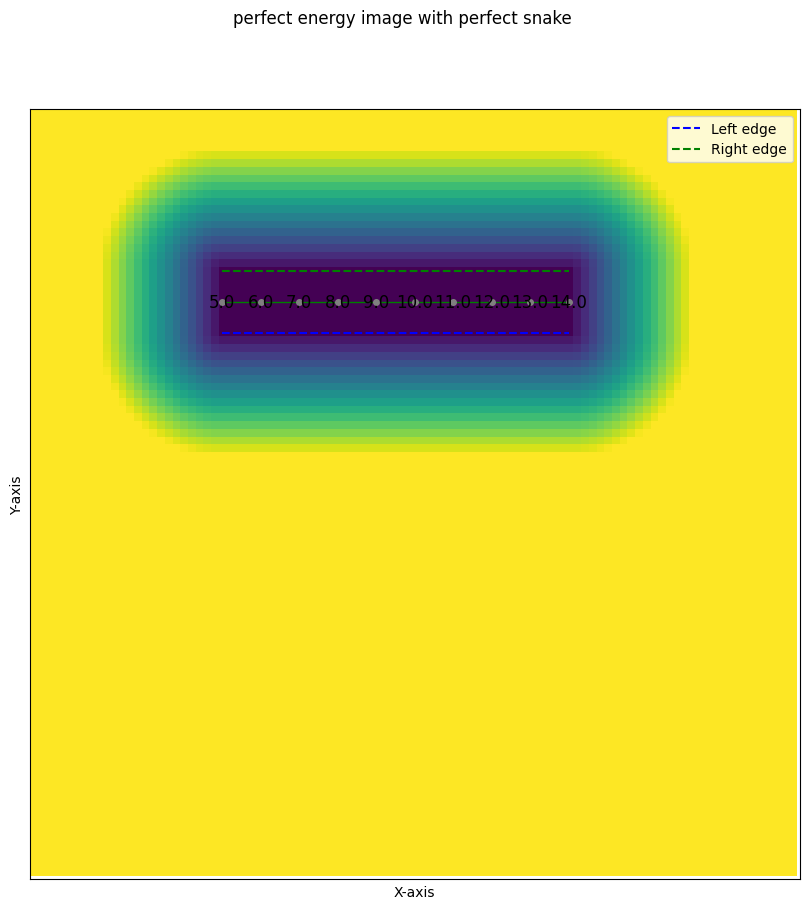

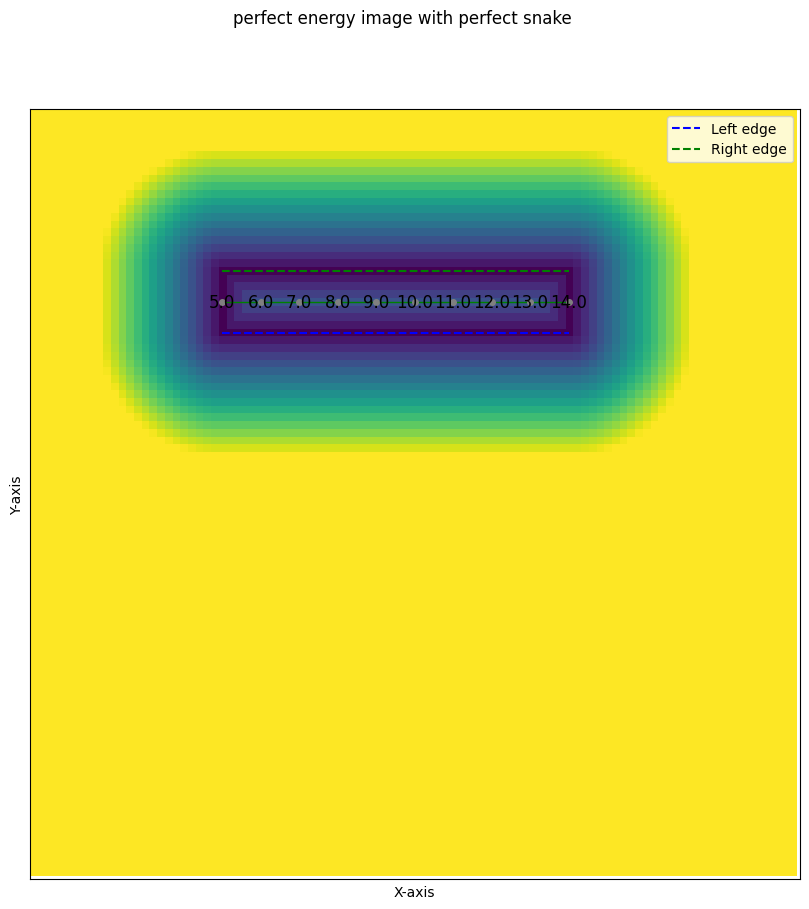

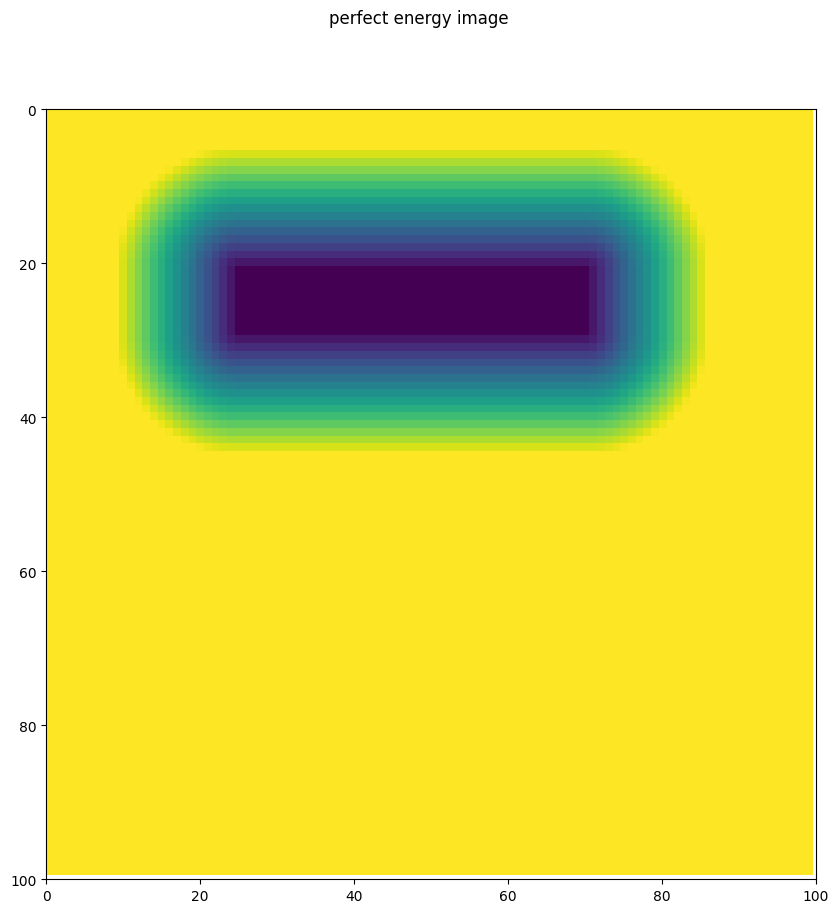

In [87]:
g = nx.Graph()
widths = th.tensor([8.0]*10,dtype=th.float32)
for i in range(25,75,5):  # Start from 0
    g.add_node(i/5, pos=np.array([25, i]))
    if i > 25:
        g.add_edge(i/5, i/5 - 1)
        
stepsz = 0.33
alpha = 0.1
beta = 0.1
crop = [slice(0, 200), slice(0, 200)]
ndims = 2

s = RibbonSnake(g, crop, stepsz, alpha, beta, None, None)
s.set_w(th.tensor(widths, dtype=th.float32).view(-1, 1))

gra = s.getGraph()
nodes = [gra.nodes[n]['pos'] for n in gra.nodes()]
widths = s.get_w().flatten()
samples_to_widths = list(zip(nodes, widths))

norms_perf = s._compute_normals_complex(s.s)
dismap1N = render_distance_map_2d1F(samples_to_widths, [100, 100], norms_perf)
dismap1W = render_distance_map_2d1FW(samples_to_widths, [100, 100], norms_perf)
# for the values in distance map, if a value is higher than 16 I want it to automatically set to 16
dismap1N = torch.clamp(dismap1N, max=16)
dismap1W = torch.clamp(dismap1W, max=16)

v_L_perf = (s.s - s.w / 2.0 * norms_perf).detach().cpu().numpy()
v_R_perf = (s.s + s.w / 2.0 * norms_perf).detach().cpu().numpy()

showriba(dismap1N.detach().cpu().numpy(), 'perfect energy image with perfect snake', gra, v_L_perf, v_R_perf)
showriba(dismap1W.detach().cpu().numpy(), 'perfect energy image with perfect snake', gra, v_L_perf, v_R_perf)

size = [100, 100]
cropsz = [16, 16]
dmax = 16
maxedge = 4

del s

for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([10,0])

pred=dismap1N.clone()[None,None]
predw = dismap1W.clone()[None,None]

show(dismap1N.detach().numpy(),"perfect energy image")

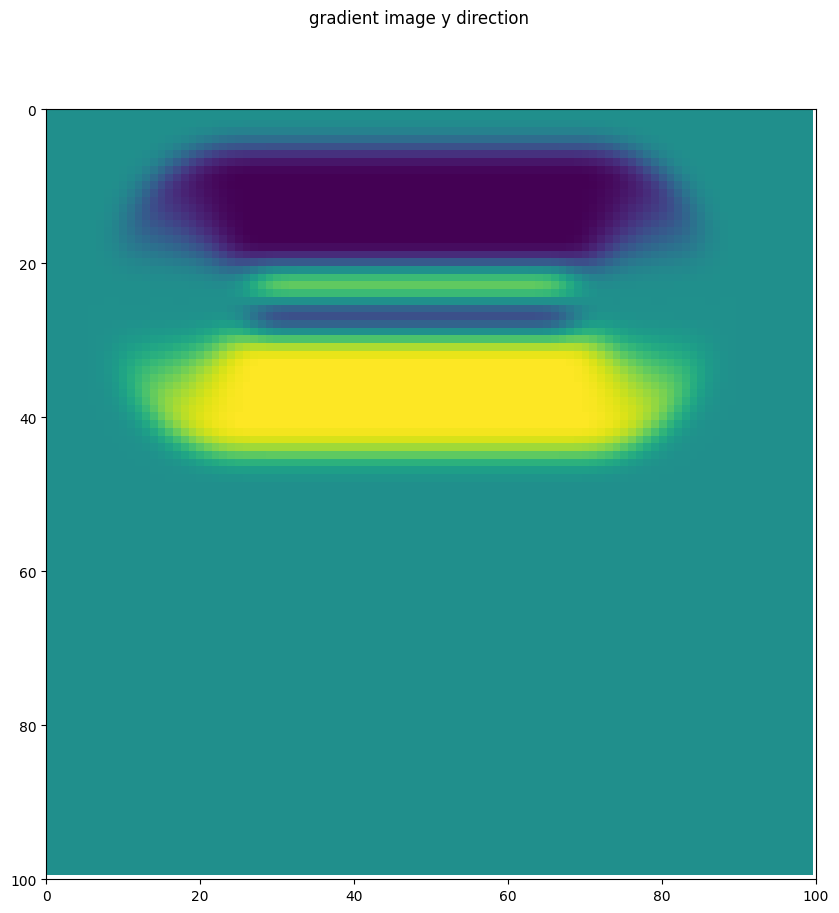

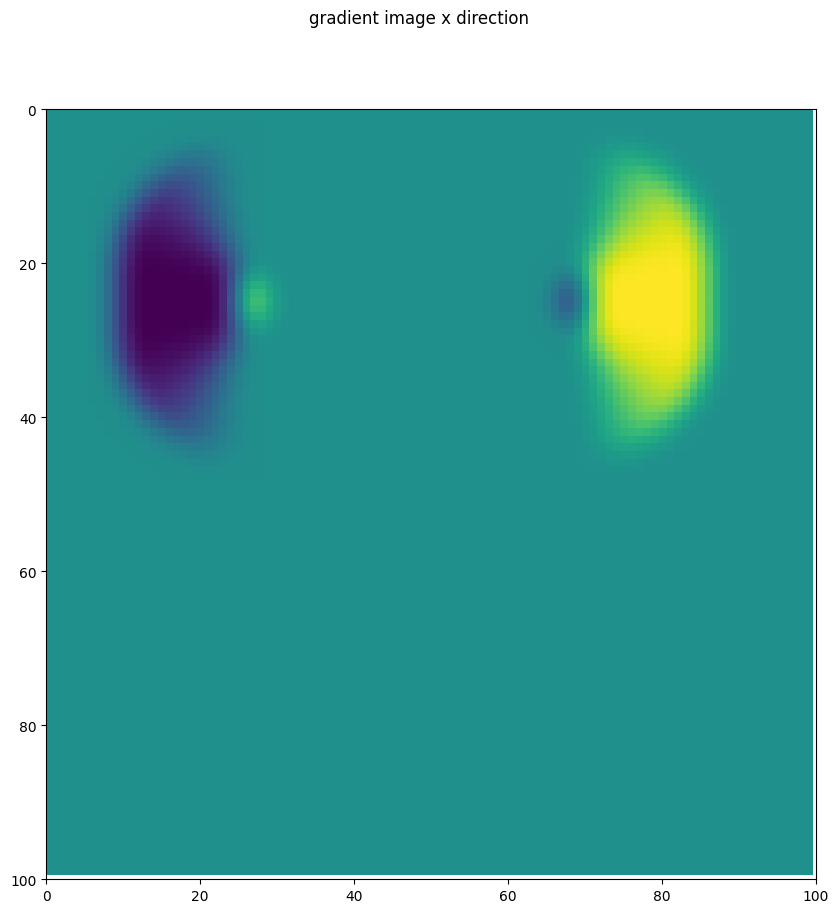

In [88]:
fltr = makeGaussEdgeFltr(1.0,2)
fltr_w = makeGaussEdgeFltr(2.0,2)
fltrtr = th.from_numpy(fltr).type(th.float32)
fltrtr_w = th.from_numpy(fltr_w).type(th.float32)

gimg = cmptGradIm(pred,fltrtr)
gimgw = cmptGradIm(predw,fltrtr_w)

""" show(gimg[0][0].detach().numpy(),"gradient image y direction")
show(gimg[0][1].detach().numpy(),"gradient image x direction") """

extgradfac=1.0
gimg = gimg[0]
gimgw = gimgw[0]

show(gimgw[0].detach().numpy(),"gradient image y direction")
show(gimgw[1].detach().numpy(),"gradient image x direction")

croprib=[slice(0,200), slice(0,200)]

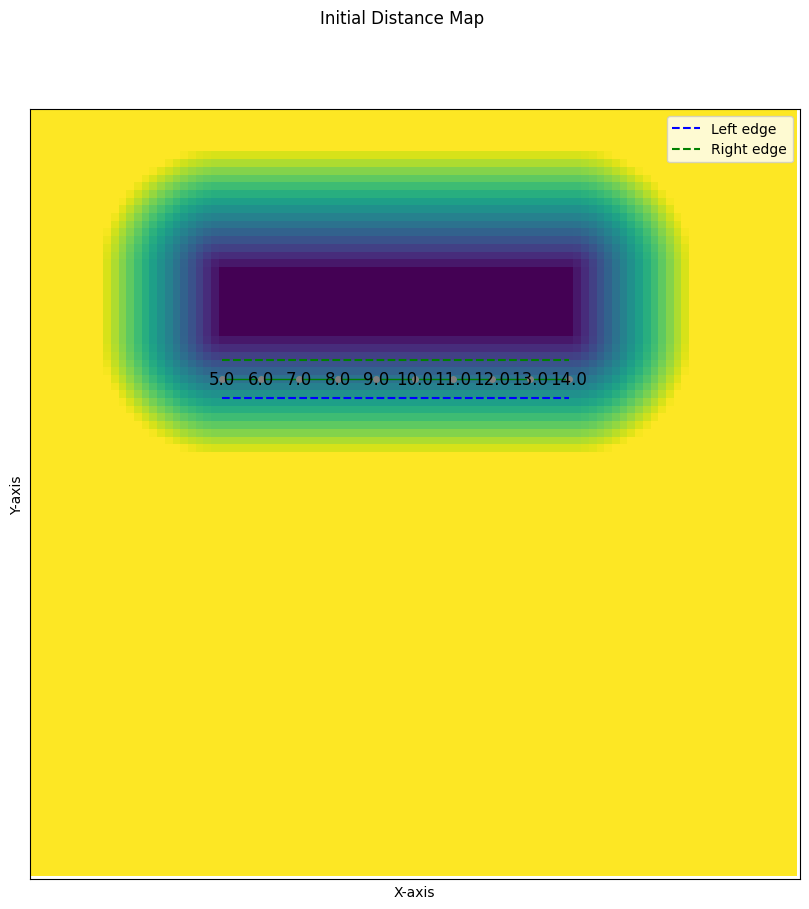

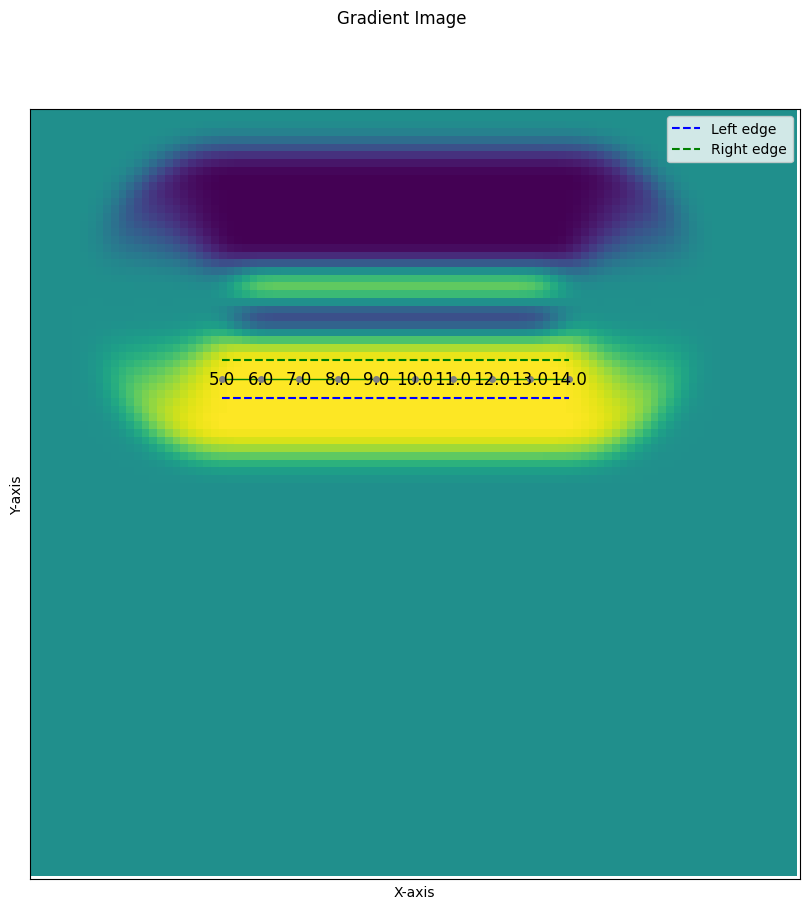

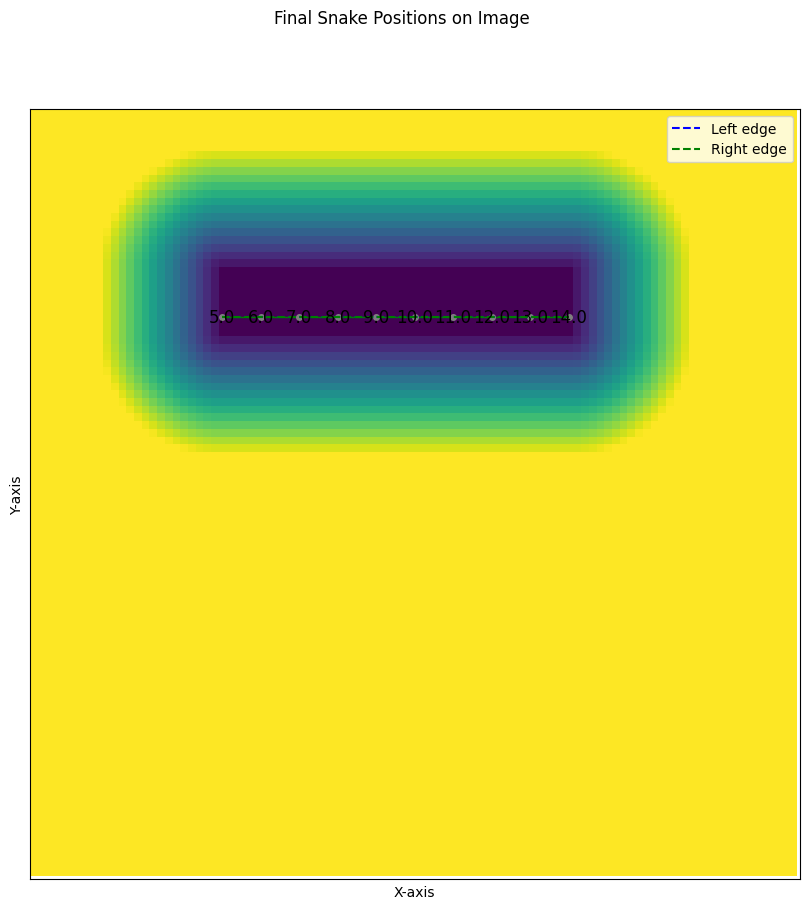

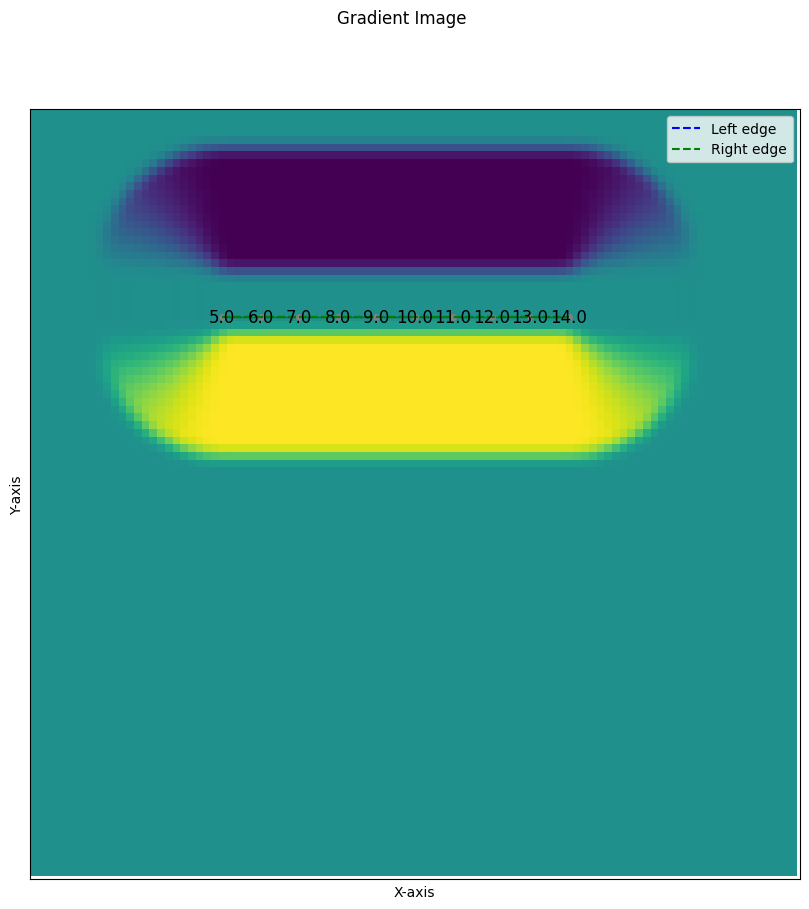

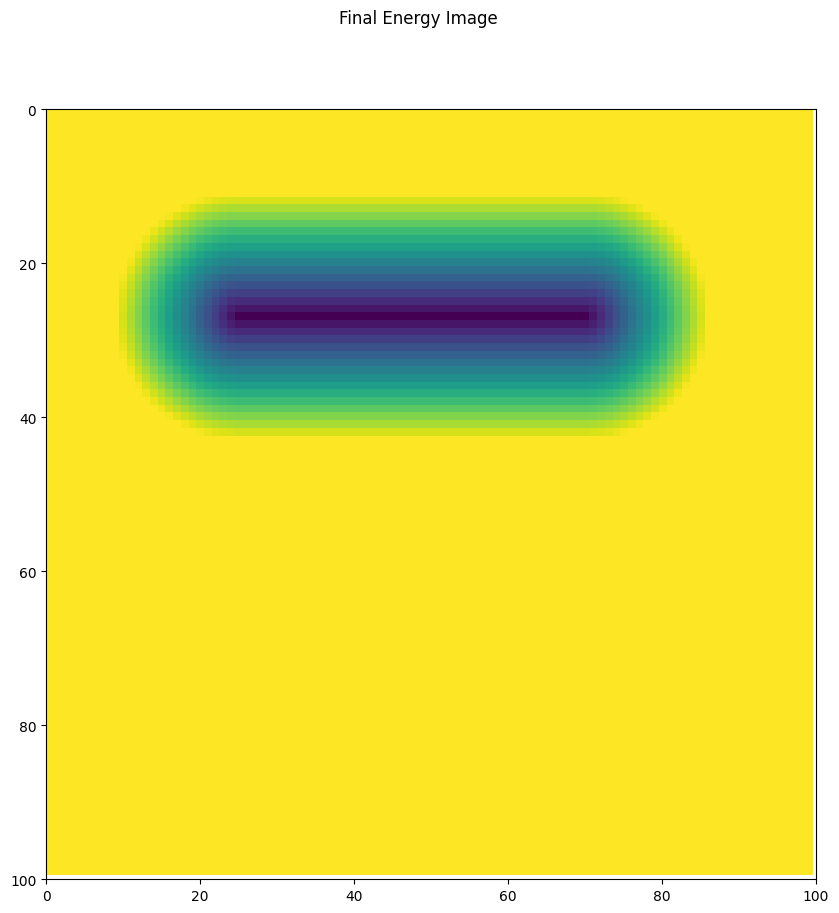

In [92]:
sa=RibbonSnake(g,croprib,stepsz,alpha,beta,gimg, gimgw, step_type="stiff")
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)
# Plot the image
norms_prev = sa._compute_normals_complex(sa.s)
v_L_prev = (sa.s - sa.w * norms_prev / 2).detach().cpu().numpy()
v_R_prev = (sa.s + sa.w * norms_prev / 2).detach().cpu().numpy()
showriba(pred[0, 0].detach().cpu().numpy(), 'Initial Distance Map', sa.getGraph(), v_L_prev, v_R_prev)
showriba(gimgw[0].detach().cpu().numpy(), 'Gradient Image', sa.getGraph(), v_L_prev, v_R_prev)

last = sa.optim(1000)
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)

# Get the final positions of the snake nodes
final_positions = sa.get_s().detach().cpu().numpy()
norms = sa._compute_normals_complex(sa.s)
v_L = (sa.s - sa.w * norms / 2).detach().cpu().numpy()
v_R = (sa.s + sa.w * norms / 2).detach().cpu().numpy()

# Plot the snake nodes
showriba(pred[0, 0].detach().cpu().numpy(), 'Final Snake Positions on Image', sa.getGraph(), v_L, v_R)
showriba(gimg[0].detach().cpu().numpy(), 'Gradient Image', sa.getGraph(), v_L, v_R)

gra = sa.getGraph()
nodes = [gra.nodes[n]['pos'] for n in gra.nodes()]
widths = sa.get_w().flatten()
samples_to_widths = list(zip(nodes, widths))
dis_final = render_distance_map_2d1F(samples_to_widths, [100, 100], norms)
dis_final = torch.clamp(dis_final, max=16)
show(dis_final.detach().cpu().numpy(), 'Final Energy Image')

# ----------------------

# Weird Example

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


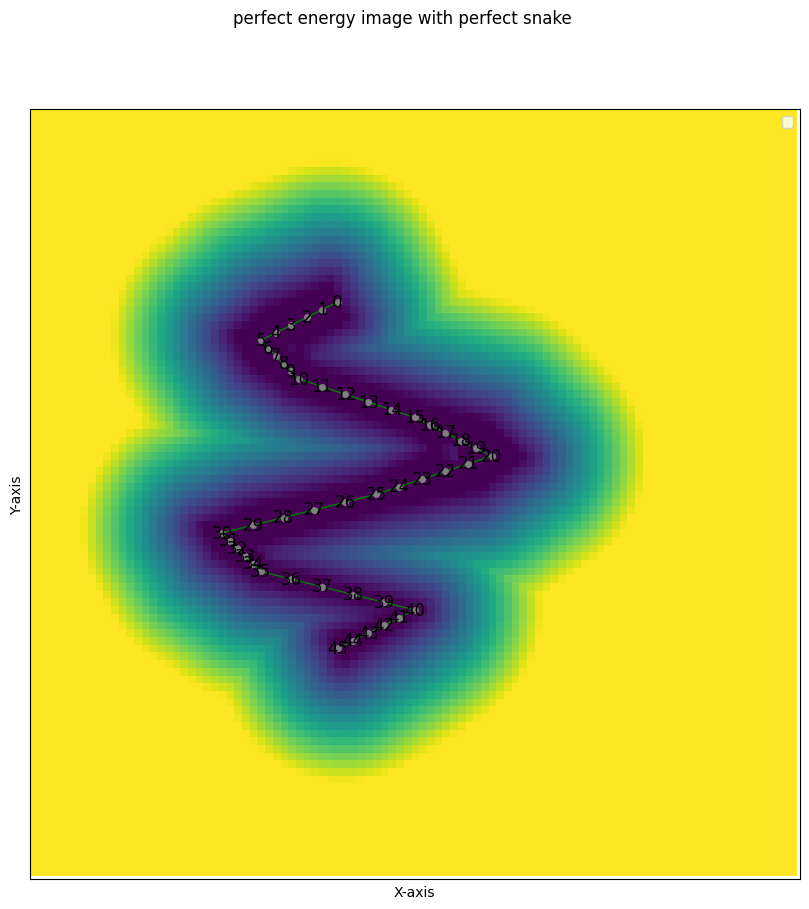

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


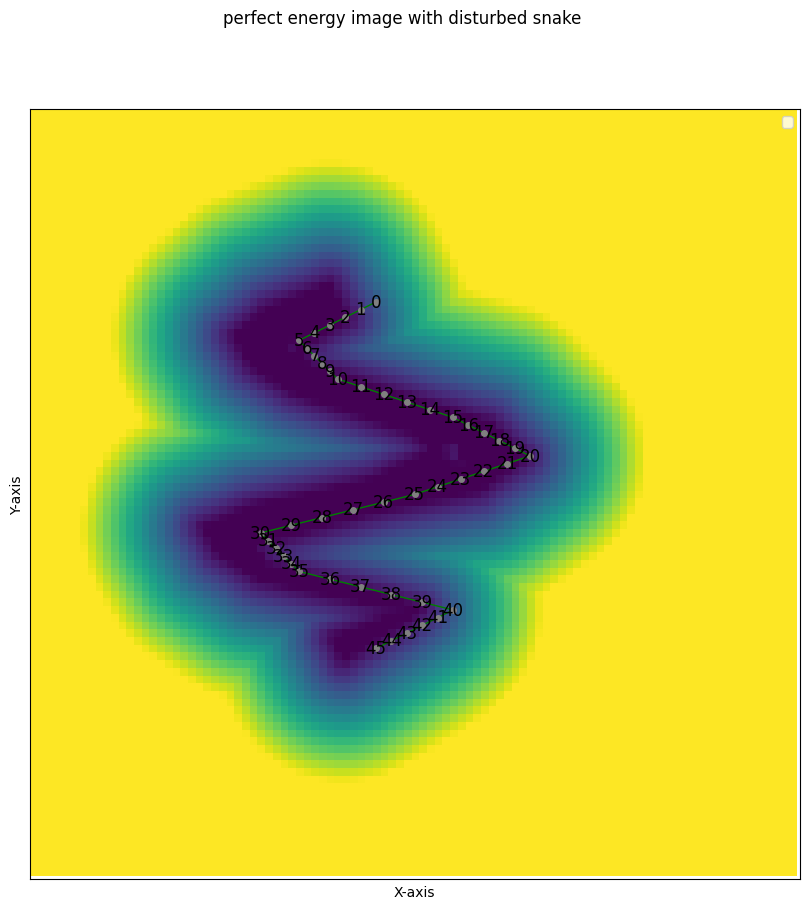

In [75]:
node_positions = [
    (25, 40), (30, 30), (35, 35), (40, 50),
    (45, 60), (50, 45), (55, 25), (60, 30),
    (65, 50), (70, 40)
]
widths = [5, 7, 4, 4, 8, 4, 5, 2, 1, 3]

g = nx.Graph()

node_index = 0

g.add_node(node_index, pos=np.array(node_positions[0]), width=widths[0])
last_node_index = node_index

for i in range(len(node_positions) - 1):
    start_pos = np.array(node_positions[i])
    end_pos = np.array(node_positions[i + 1])
    start_width = widths[i]
    end_width = widths[i + 1]
    
    for j in range(1, 5):
        fraction = j / 5
        pos = start_pos + fraction * (end_pos - start_pos)
        width_val = start_width + fraction * (end_width - start_width)
        node_index += 1
        g.add_node(node_index, pos=pos, width=width_val)
        g.add_edge(last_node_index, node_index)
        last_node_index = node_index
        
    node_index += 1
    g.add_node(node_index, pos=np.array(node_positions[i + 1]), width=end_width)
    g.add_edge(last_node_index, node_index)
    last_node_index = node_index

widths_array = [g.nodes[node]['width'] for node in g.nodes()]

stepsz = 0.33
alpha = 0.1
beta = 0.1
crop = [slice(0, 200), slice(0, 200)]
ndims = 2

s = RibbonSnake(g, crop, stepsz, alpha, beta, None, None)
s.set_w(np.array(widths_array))

gra = s.getGraph()
nodes = [gra.nodes[n]['pos'] for n in gra.nodes()]
widths = s.get_w().flatten()
samples_to_widths = list(zip(nodes, widths))

dismap1 = render_distance_map_2d1F(samples_to_widths, [100, 100], s._compute_normals_complex(s.s))
dismap1W = render_distance_map_2d1FW(samples_to_widths, [100, 100], s._compute_normals_complex(s.s))
# for the values in distance map, if a value is higher than 16 I want it to automatically set to 16
dismap1 = torch.clamp(dismap1, max=16)
dismap1W = torch.clamp(dismap1W, max=16)
showriba(dismap1.detach().cpu().numpy(), 'perfect energy image with perfect snake', gra)

size = [100, 100]
cropsz = [16, 16]
dmax = 16
maxedge = 4

#del s

""" disturbances = [
    (0, 5), (0, -3), (0, 7), (0, 0), (0, 6), 
    (0, 1), (0, 7), (0, 2), (0, -5), (0, 1)
]

for i, pos in enumerate(disturbances):
    g.nodes[i]["pos"] += np.array(pos) """

for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([0,5])

pred = dismap1.clone()[None, None]
predW = dismap1W.clone()[None, None]

showriba(pred[0,0].detach().numpy(), "perfect energy image with disturbed snake", g)

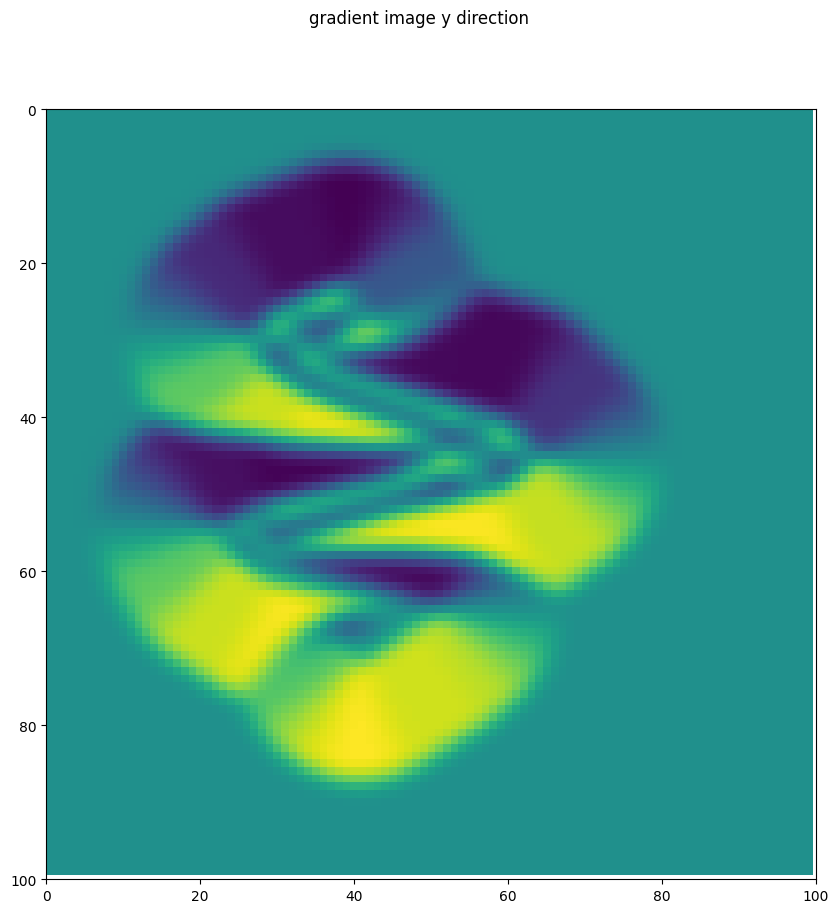

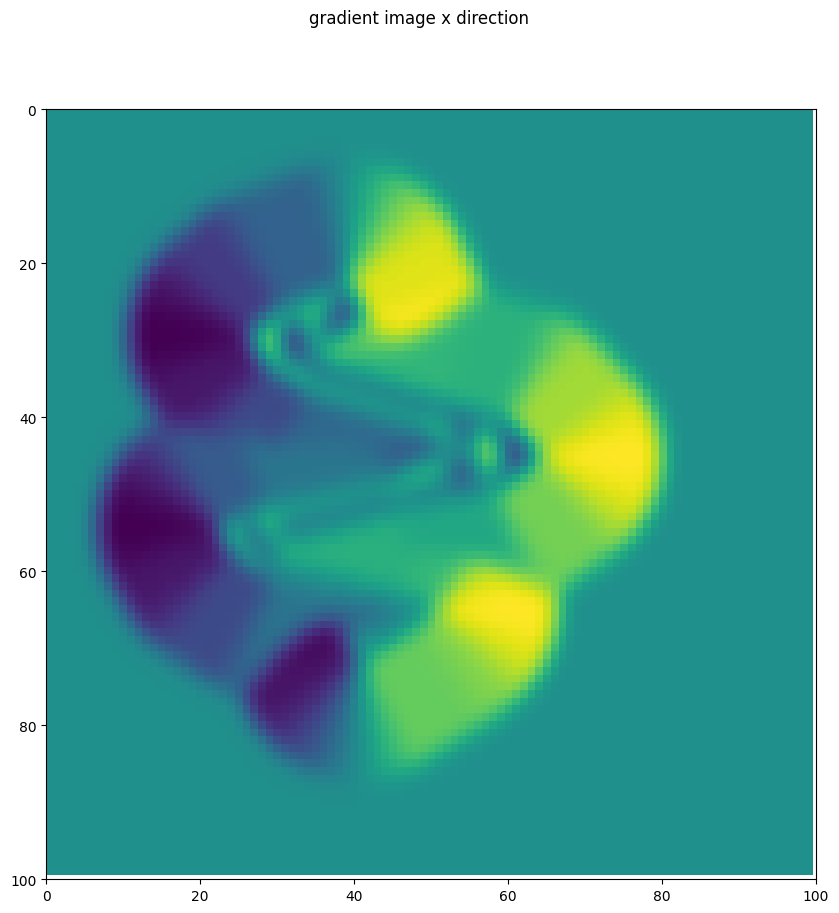

In [76]:
fltr = makeGaussEdgeFltr(1.0,2)
fltr_w = makeGaussEdgeFltr(1.5,2)
fltrtr = th.from_numpy(fltr).type(th.float32)
fltrtr_w = th.from_numpy(fltr_w).type(th.float32)

gimg = cmptGradIm(pred,fltrtr)
gimgW = cmptGradIm(predW,fltrtr_w)

extgradfac=1.0
gimg = gimg[0]
gimgW = gimgW[0]
croprib=[slice(0,200), slice(0,200)]

show(gimgW[0].detach().numpy(),"gradient image y direction")
show(gimgW[1].detach().numpy(),"gradient image x direction")

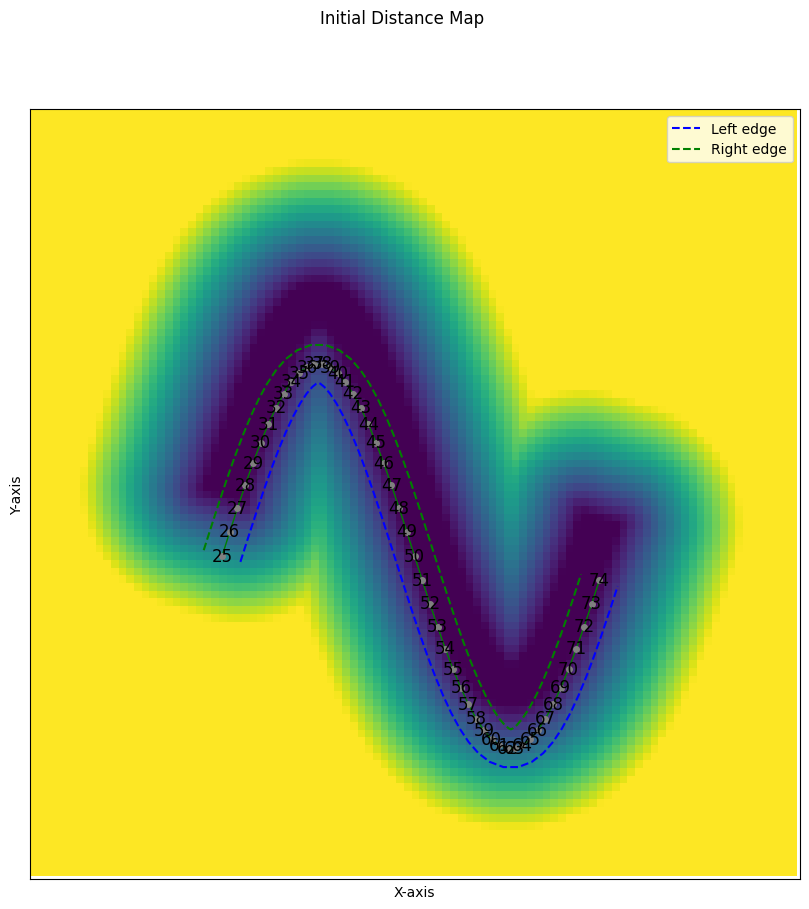

TypeError: RibbonSnake.comp_second_deriv() takes 1 positional argument but 3 were given

In [85]:
sb=RibbonSnake(g,croprib,stepsz,alpha,beta,gimg, gimgW, step_type="stiff")
#sb.set_w(th.tensor(widths, dtype=th.float32).view(-1, 1))
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)
# Plot the image
norms_prev = sb._compute_normals_complex(sb.s)
v_L_prev = (sb.s - sb.w * norms_prev / 2).detach().cpu().numpy()
v_R_prev = (sb.s + sb.w * norms_prev / 2).detach().cpu().numpy()
showriba(pred[0, 0].detach().cpu().numpy(), 'Initial Distance Map', sb.getGraph(), v_L_prev, v_R_prev)

last = sb.optim(1000)
#print("Node positions: ", sb.s)
#print("Node widths: ",sb.w)

# Get the final positions of the snake nodes
final_positions = sb.get_s().detach().cpu().numpy()
norms = sb._compute_normals_complex(sb.s)
v_L = (sb.s - sb.w * norms / 2).detach().cpu().numpy()
v_R = (sb.s + sb.w * norms / 2).detach().cpu().numpy()

# Plot the snake nodes
showriba(pred[0, 0].detach().cpu().numpy(), 'Final Snake Positions on Image', sb.getGraph(), v_L, v_R)
showriba(gimg[0].detach().cpu().numpy(), 'Gradient Image', sb.getGraph(), v_L, v_R)

gra = sb.getGraph()
nodes = [gra.nodes[n]['pos'] for n in gra.nodes()]
widths = sb.get_w().flatten()
samples_to_widths = list(zip(nodes, widths))
dis_final = render_distance_map_2d1F(samples_to_widths, [100, 100], norms)
dis_final = torch.clamp(dis_final, max=16)

dis_diff = dis_final - dismap1

show(dis_final.detach().cpu().numpy(), 'Final Energy Image')
show(dis_diff.detach().cpu().numpy(), 'Difference of Final and First Energy Image')

# Sine

In [74]:
from math import sin,pi

C:\Users\serta\AppData\Local\Temp\ipykernel_24140\3749098319.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s.set_w(th.tensor(widths, dtype=th.float32).view(-1, 1))


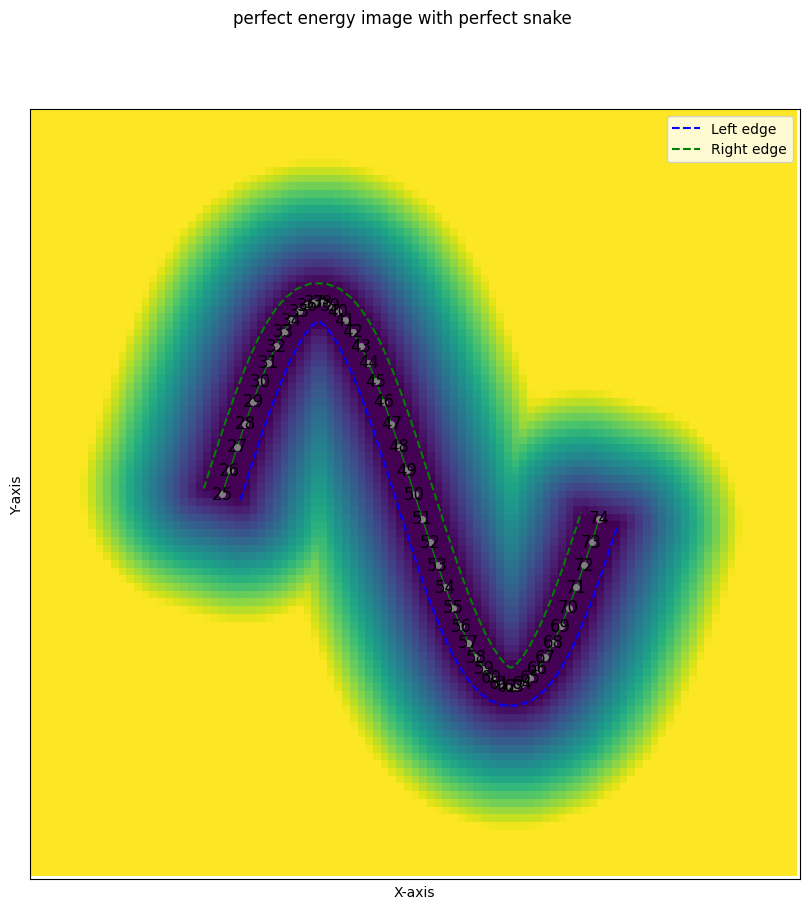

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


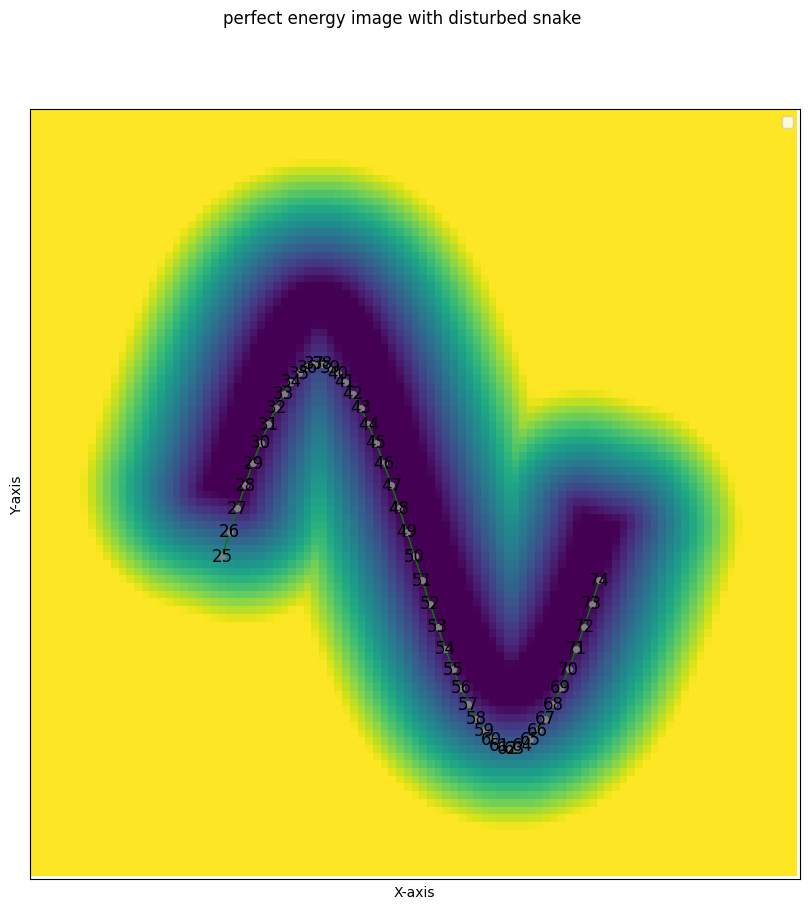

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


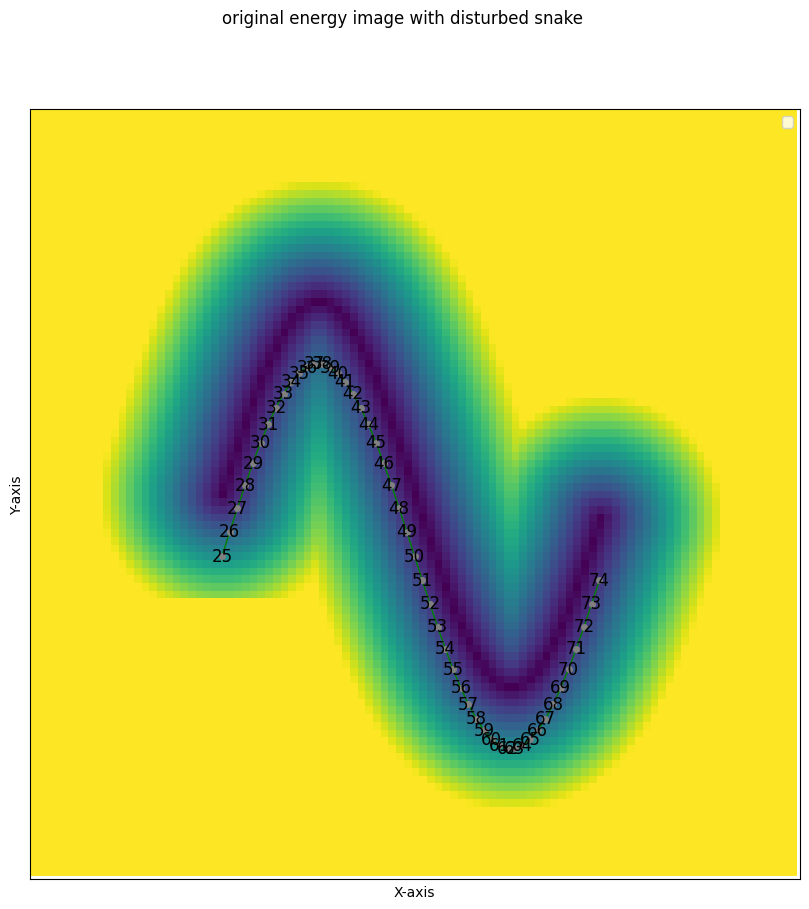

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


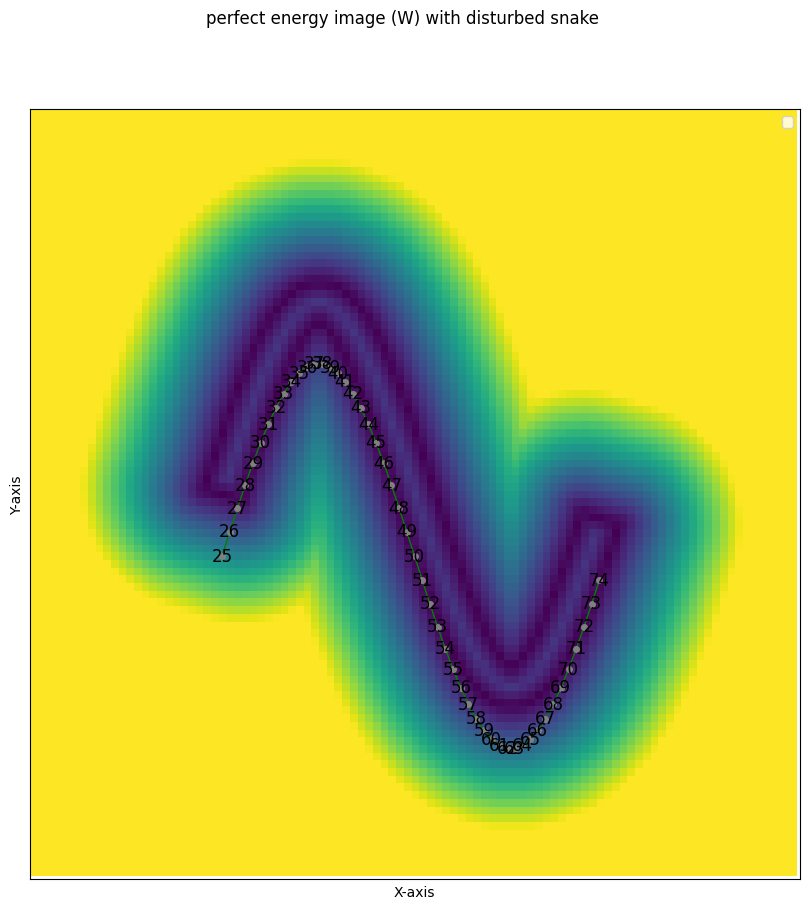

In [78]:
g=nx.Graph()
widths = th.tensor([5.0]*50,dtype=th.float32)
for i in range(25,75):
    g.add_node(i,pos=np.array([sin(i*2*pi/50.0)*25+50,i]))
    if i>25:
        g.add_edge(i,i-1)

stepsz = 0.33
alpha = 0
beta = 0
crop = [slice(0, 200), slice(0, 200)]
ndims = 2

s = RibbonSnake(g, crop, stepsz, alpha, beta, None, None)
s.set_w(th.tensor(widths, dtype=th.float32).view(-1, 1))

gra = s.getGraph()
nodes = [gra.nodes[n]['pos'] for n in gra.nodes()]
widths = s.get_w().flatten()
samples_to_widths = list(zip(nodes, widths))

norms_perf = s._compute_normals_complex(s.s)
dismap1 = render_distance_map_2d1F(samples_to_widths, [100, 100], norms_perf)
dismap_w = render_distance_map_2d1FW(samples_to_widths, [100, 100], norms_perf)
dismap_original = s.renderDistanceMap([100, 100], [16, 16], 16, 4)
# for the values in distance map, if a value is higher than 16 I want it to automatically set to 16
dismap1 = torch.clamp(dismap1, max=16)
dismap_w = torch.clamp(dismap_w, max=16)

v_L_perf = (s.s - s.w / 2.0 * norms_perf).detach().cpu().numpy()
v_R_perf = (s.s + s.w / 2.0 * norms_perf).detach().cpu().numpy()

showriba(dismap1.detach().cpu().numpy(), 'perfect energy image with perfect snake', gra, v_L_perf, v_R_perf)

size = [100, 100]
cropsz = [16, 16]
dmax = 16
maxedge = 4

#del s

for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([8,0])

pred = dismap1.clone()[None, None]
pred_w = dismap_w.clone()[None, None]
pred_orig = dismap_original.clone()[None, None]

showriba(pred[0,0].detach().numpy(), "perfect energy image with disturbed snake", g)
showriba(pred_orig[0,0].detach().numpy(), "original energy image with disturbed snake", g)
showriba(pred_w[0,0].detach().numpy(), "perfect energy image (W) with disturbed snake", g)

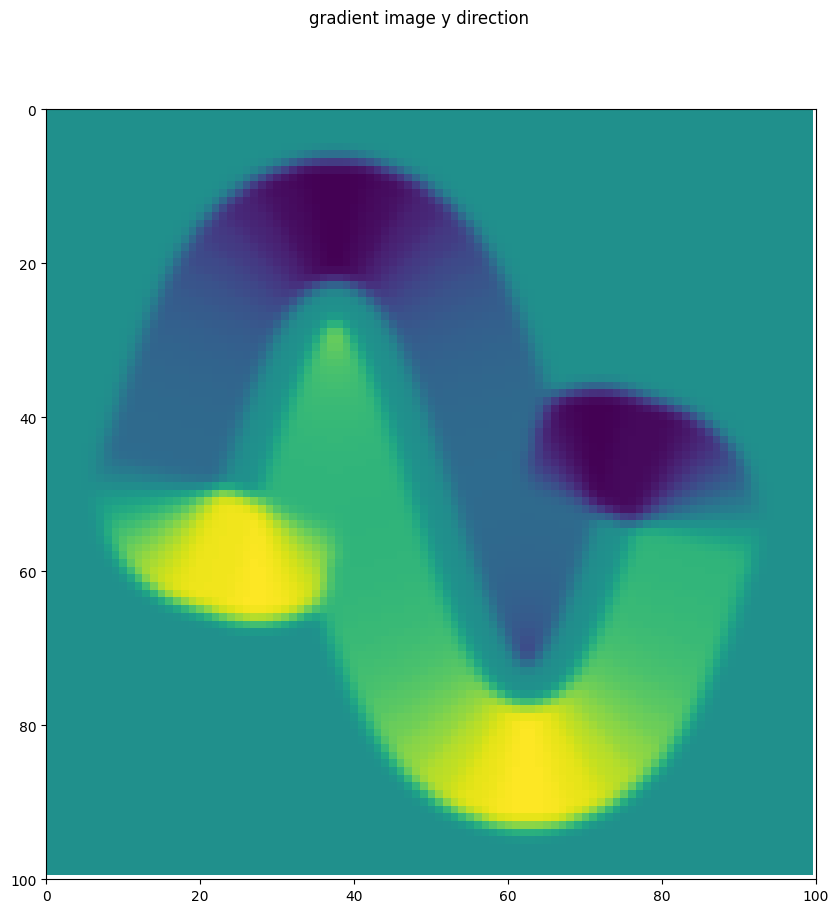

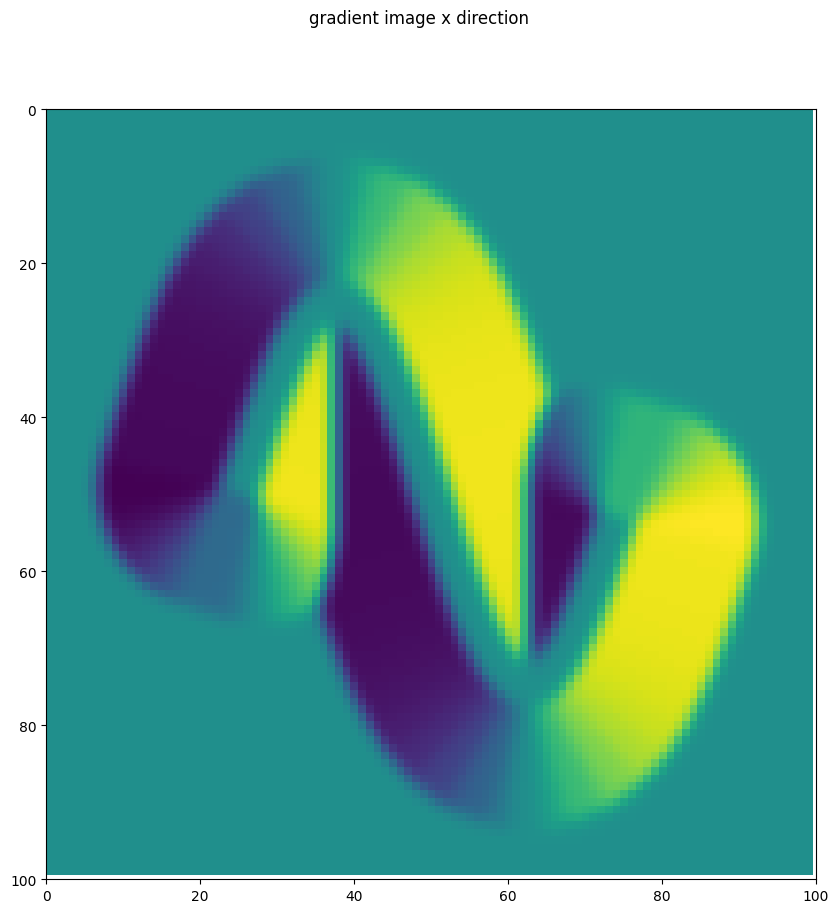

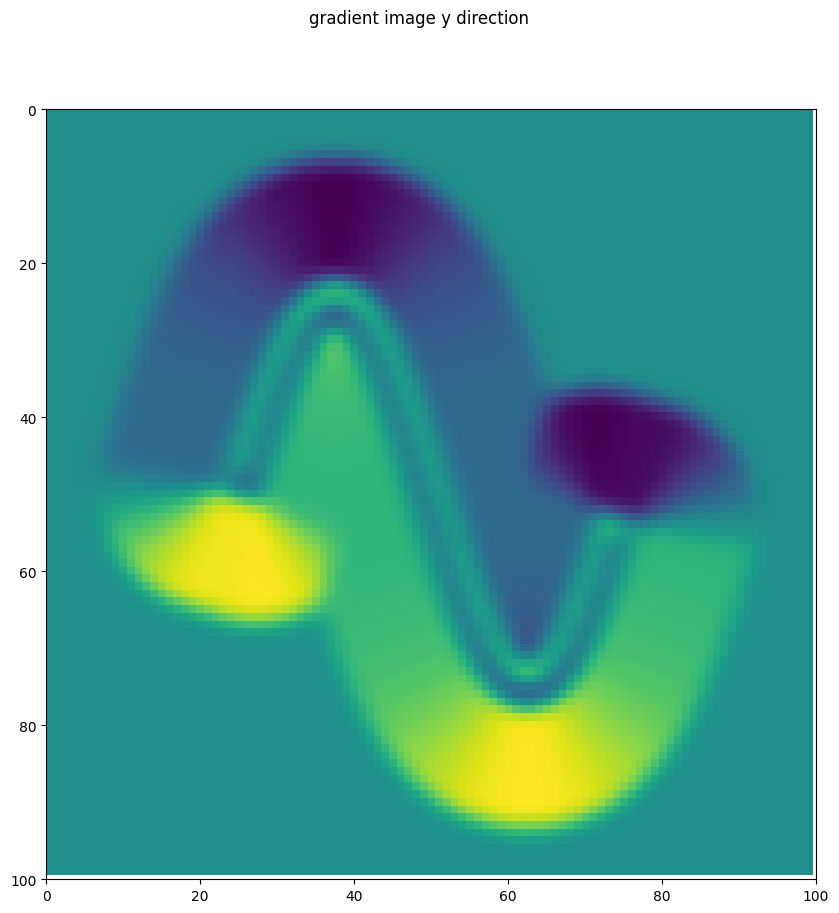

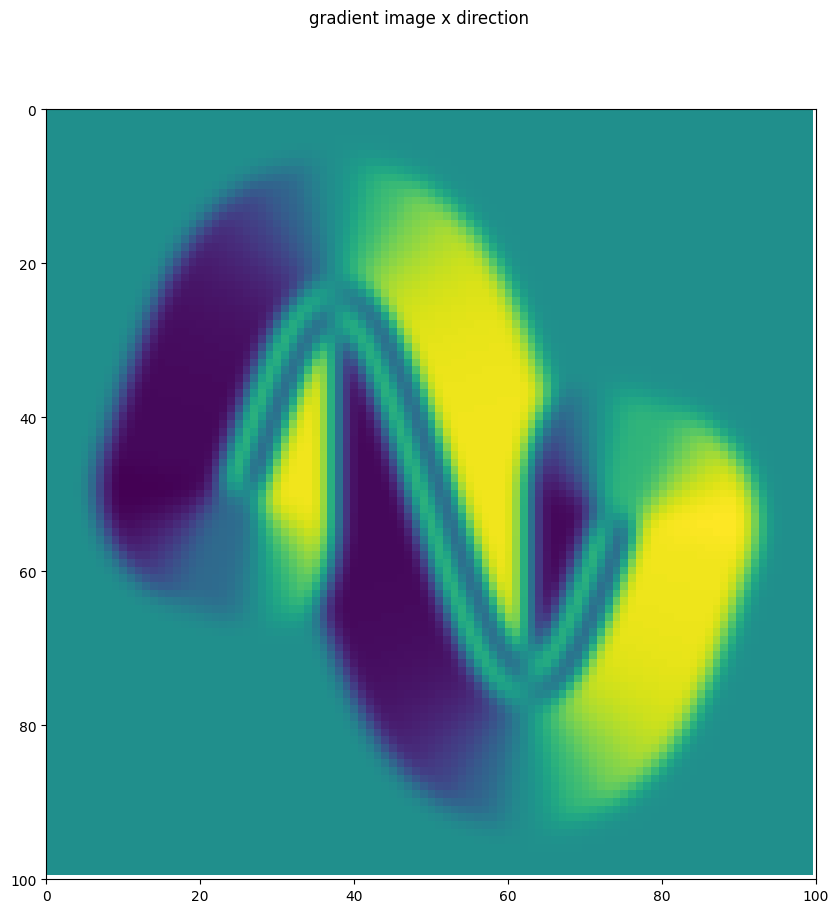

In [79]:
fltr = makeGaussEdgeFltr(1.0,2)
fltr_w = makeGaussEdgeFltr(1.5,2)
fltrtr = th.from_numpy(fltr).type(th.float32)
fltrtr_w = th.from_numpy(fltr_w).type(th.float32)
gimg = cmptGradIm(pred,fltrtr)
gimgw = cmptGradIm(pred_w,fltrtr_w)

show(gimg[0][0].detach().numpy(),"gradient image y direction")
show(gimg[0][1].detach().numpy(),"gradient image x direction")

show(gimgw[0][0].detach().numpy(),"gradient image y direction")
show(gimgw[0][1].detach().numpy(),"gradient image x direction")

extgradfac=1.0
gimg = gimg[0]
gimgw = gimgw[0]

croprib=[slice(0,200), slice(0,200)]

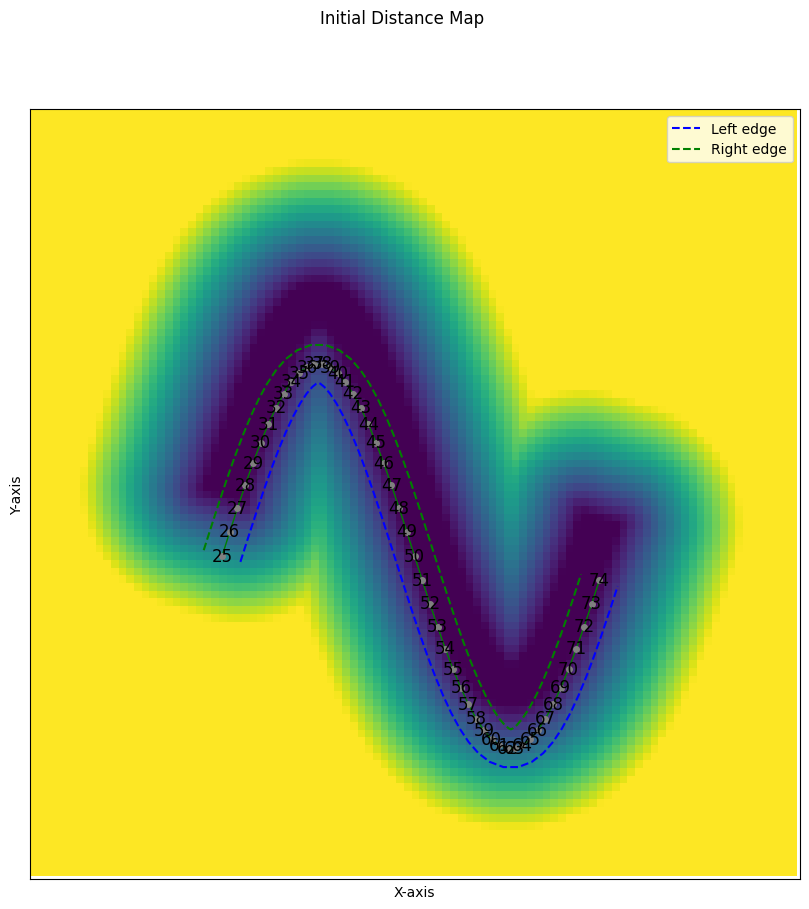

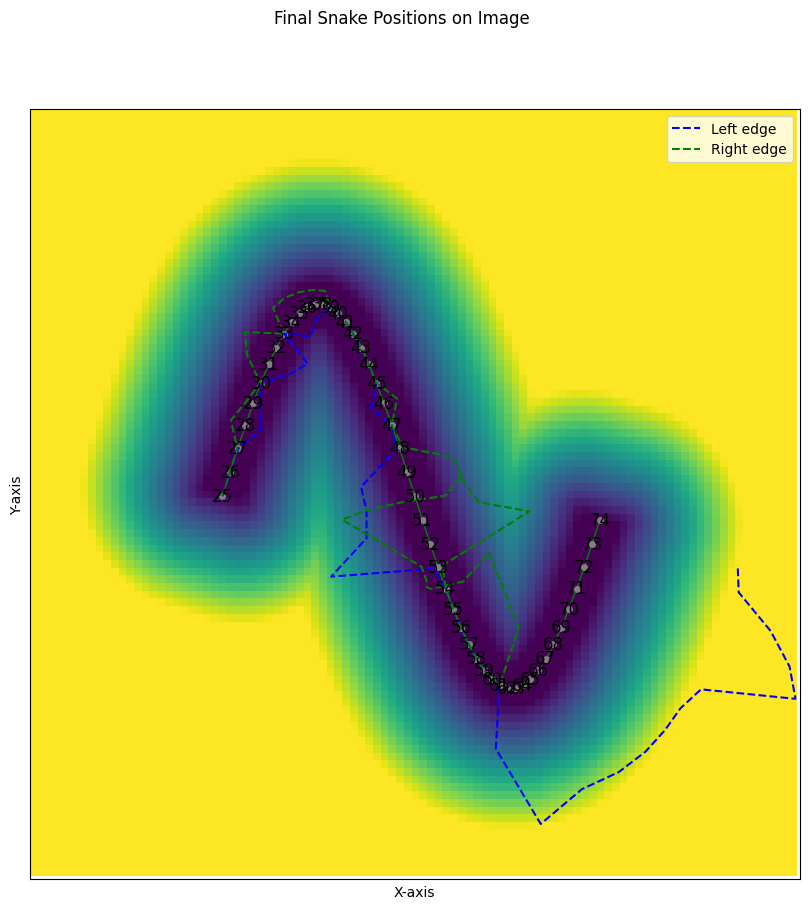

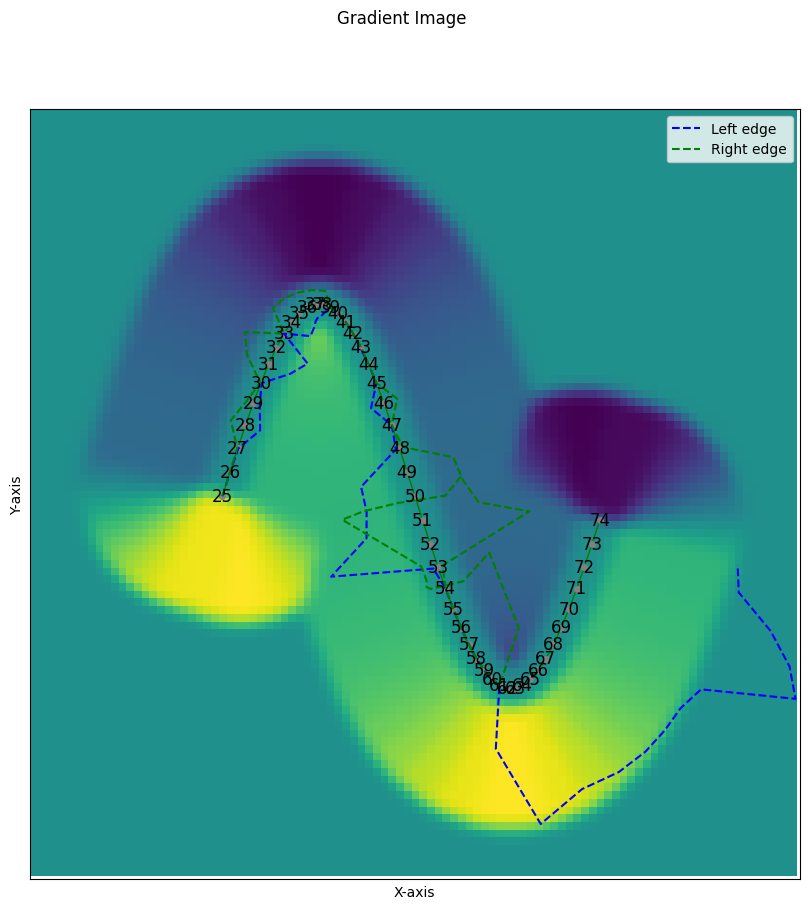

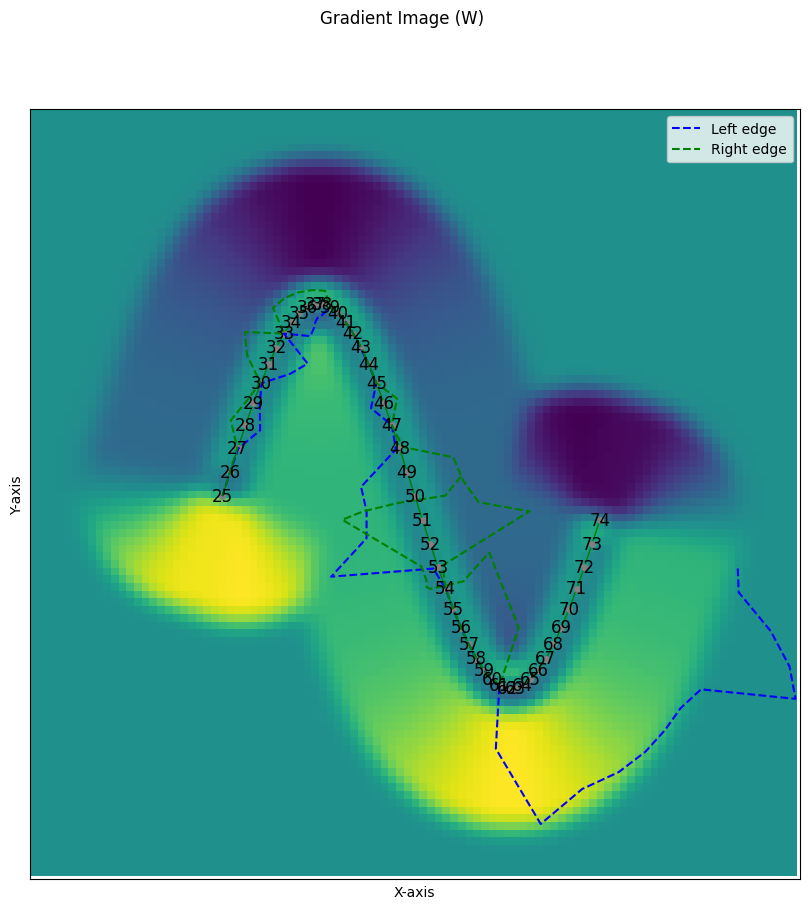

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


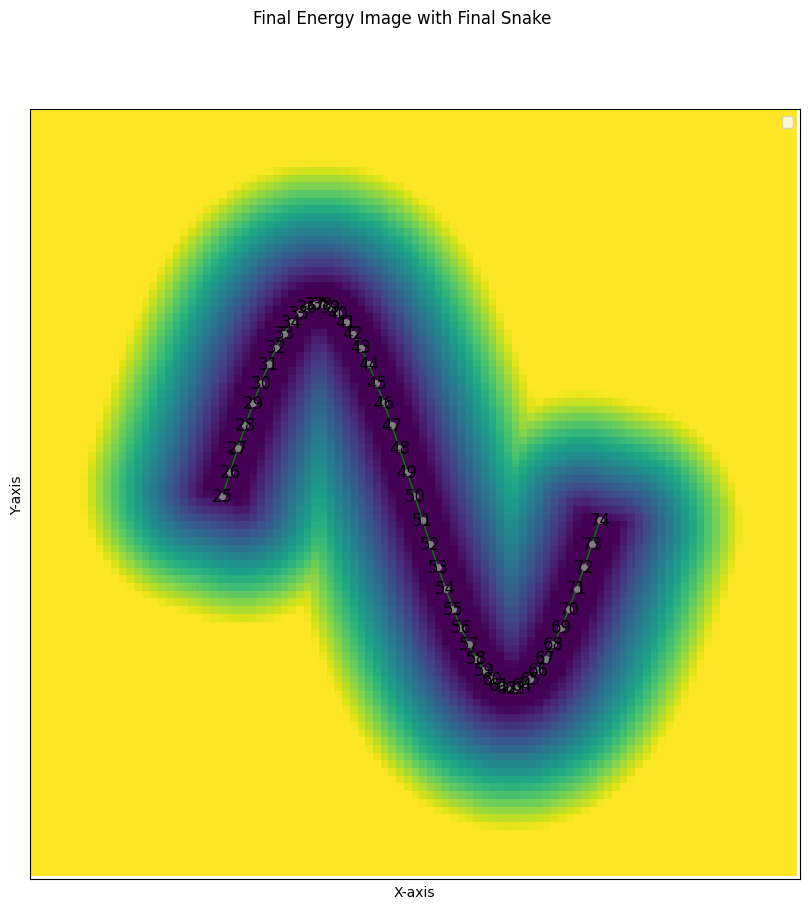

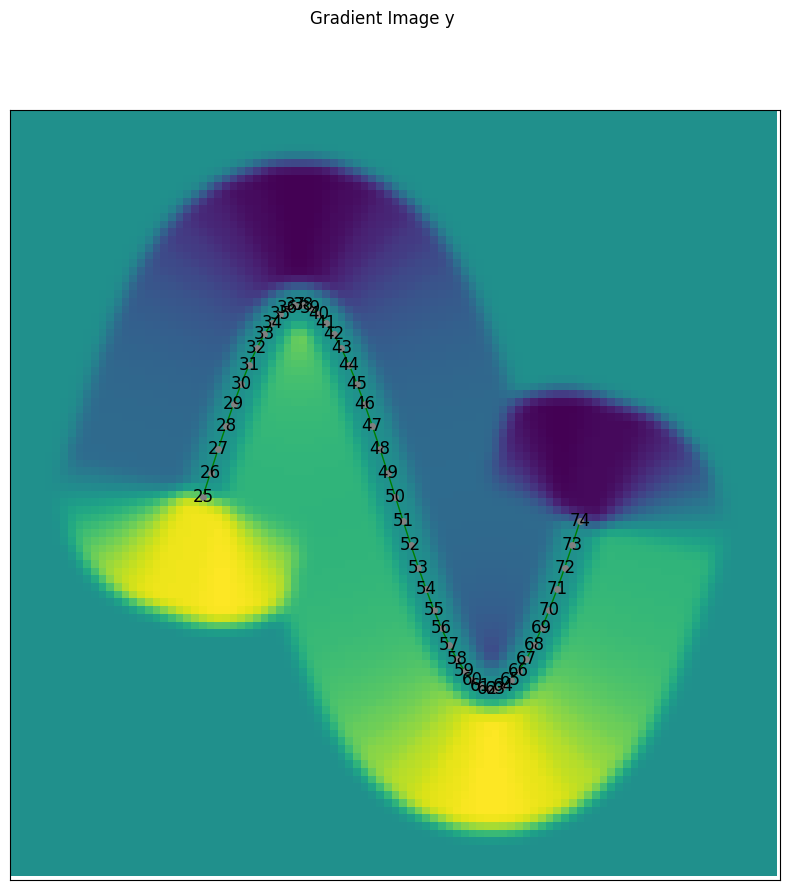

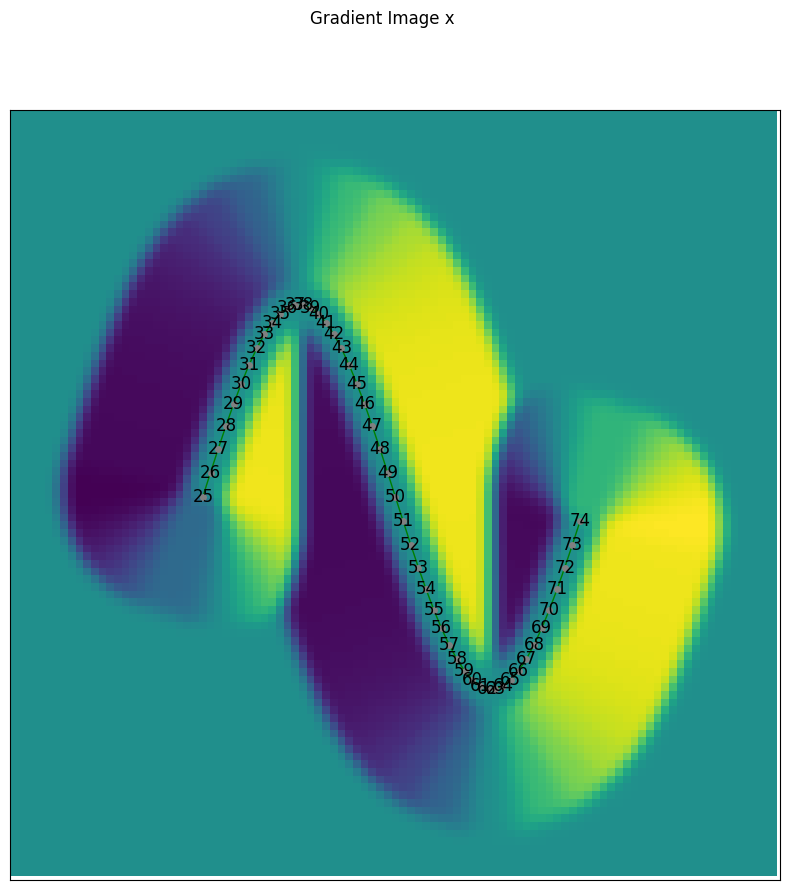

In [83]:
sb=RibbonSnake(g,croprib,stepsz,alpha,beta,gimg, gimgW, step_type="stiff")
#sb.set_w(th.tensor(widths, dtype=th.float32).view(-1, 1))
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)
# Plot the image
norms_prev = sb._compute_normals_complex(sb.s)
v_L_prev = (sb.s - sb.w / 2.0 * norms_prev).detach().cpu().numpy()
v_R_prev = (sb.s + sb.w / 2.0 * norms_prev).detach().cpu().numpy()
showriba(pred[0, 0].detach().cpu().numpy(), 'Initial Distance Map', sb.getGraph(), v_L_prev, v_R_prev)

last = sb.optim(500)
#print("Node positions: ", sb.s)
#print("Node widths: ",sb.w)

# Get the final positions of the snake nodes
final_positions = sb.get_s().detach().cpu().numpy()
norms = sb._compute_normals_complex(sb.s)
v_L = (sb.s - sb.w * norms / 2).detach().cpu().numpy()
v_R = (sb.s + sb.w * norms / 2).detach().cpu().numpy()

# Plot the snake nodes
showriba(pred[0, 0].detach().cpu().numpy(), 'Final Snake Positions on Image', sb.getGraph(), v_L, v_R)
showriba(gimg[0].detach().cpu().numpy(), 'Gradient Image', sb.getGraph(), v_L, v_R)
showriba(gimgw[0].detach().cpu().numpy(), 'Gradient Image (W)', sb.getGraph(), v_L, v_R)

gra_res = sb.getGraph()
nodes_res = [gra_res.nodes[n]['pos'] for n in gra_res.nodes()]
widths_res = s.get_w().flatten()
samples_to_widths_res = list(zip(nodes_res, widths_res))
dist_map_res = render_distance_map_2d1F(samples_to_widths_res, [100, 100], norms_prev)
dist_map_res = torch.clamp(dist_map_res, max=16)
showriba(dist_map_res.detach().cpu().numpy(), 'Final Energy Image with Final Snake', gra_res)

gimg_res = cmptGradIm(dist_map_res.clone()[None,None], fltrtr)
show(gimg_res[0][0].detach().numpy(), 'Gradient Image y', gra_res)
show(gimg_res[0][1].detach().numpy(), 'Gradient Image x', gra_res)